# Neural Network for Magnetometer bias calibration

The idea is to use a neural network to learn the soft iron and hard iron biases of a magnetometer from measured data. We assume that the measued magnetic field vector components $z_i$ are given as $$z_i = a_i \cdot M_i+b_i$$ 
where $M_i$ is the actual magnetic field vector component and the $a_i$, and $b_i$ unknown coefficients are due to the soft and hard iron biases respectively. We are not interested in magnitude of $\vec M$, but care about the direction or the normalized vector $\vec m = \frac{\vec M}{ 
|\vec M|}$.

What we would like to do is learn the function which gives the $m_i$ components from the measured $z_i$:s. 

## Generating training data

To develop and validate the proposed solution, we will generate some data synthetically and train the data on this data. We can then compare the resulting model to the actual data as we know the correct $\vec m$ which we will distort for training purposes. 

When this works, we should try to use some actual measurements to test out the solution.

(10000, 3)


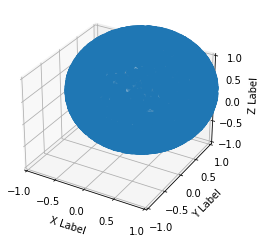

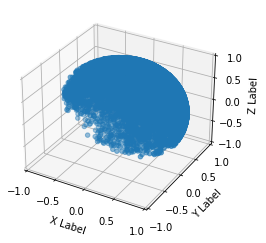

In [56]:
import numpy as np
import quaternion
import matplotlib.pyplot as plt
import random
data_length = 10000
random.seed(0)
# The absolute length is just a scaling of little significane. Experimental magnitud around 80 using MPU9050
M_norm=1.
M=np.quaternion(0,M_norm,0,0)

#print(quaternion.as_float_array(M))
#print(np.linalg.norm(quaternion.as_float_array(M)))

qs = quaternion.as_quat_array(np.random.rand(data_length, 4))

X=[]
X_ass=[]
x_prev=M
for q in qs:
    # For each random quaternion, use it to rotate M and get a new M with random orientation
    q=q.normalized()
    x=q*x_prev*q.conjugate()
    
    x_a=q*M*q.conjugate()
    X_ass.append(np.array([x_a.x,x_a.y,x_a.z]))
    
    x_prev=x
    #Create the vector from the imaginary part of the quaternion
    x=np.array([x.x,x.y,x.z])
    X.append(x)
X_ass=np.array(X_ass)
X=np.array(X)
assert X.shape[0]==data_length, "Dimension check."
assert X.shape[1]==3, "Dimension check."
cg_offset=np.sum(np.sum(np.mean(X,axis=0)**2))
assert cg_offset<0.0001, "Center of gravity check, offset: {}".format(cg_offset)
#Now we have data_length random vectors to play with.

#a is the scaling due to soft iron errors
a=np.array([1.1,1.12,1.14])
#b is the offset due to hard iron errors
b=np.array([0.11,0.13,0.15])
b=np.array([0.2,0.3,0.4])


#Generate expected Y values
Y=X

#Apply error scalings and biases
for row_i in range(X.shape[0]):
    X[row_i]=X[row_i]*a+b    

print(X.shape)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X.T[0], X.T[1], X.T[2], marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_aspect("auto")
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_ass.T[0], X_ass.T[1], X_ass.T[2], marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_aspect("auto")
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
plt.show()

## Defining a loss function

The physical situation demands that the $\vec m$ should be constant in magnitude whatever we do to the system, we will only rotate the vector in space. There might be situations where there are (local) external magnetic fields and thus $\vec m$ is depends on the position in space. We shall omit this possibility.

The asumptions above implies that $|\vec m|$ is constant regardless of how we rotate the system. Note that the magnitude $|\vec z|$ is not constant. The magnitude of $|\vec m|$ 

We should thus be able to use a loss function of the form 
$$L=(|\vec m|-1)^2$$

One issue (probably) is that when we measure a loss, the backprop will no know which weight to blame. 
This is because all vector components are adding equally to the loss.
I cannot see an obvious way around this without labeled training data, but I have a hail-mary type of idea.

So, suppose that we add stochastic noise to the loss function somehow. 
The idea being that we can randomly move some of the weights more and some of the weights less and all the moves are proportional to the loss. 
We will then in general be moving more when the loss is high and this should (hopefully) converge to the solution in a random walk kind of maner.

In [49]:
def loss(m):
    assert m.shape[0]==3, "Input is not a vector"
    m_norm=0
    for elt in m:
        m_norm+=elt**2
    m_norm=m_norm**0.5
    return (m_norm-1)**2

import tensorflow as tf
# And turns out we need to use the keras backend to write the function
import keras.backend as kb


stochastic_noise=0

@tf.function
def keras_loss_fn(y_true,y_pred):
    rand = np.random.uniform(low=1-stochastic_noise, high=1+stochastic_noise, size=(3,))
    loss=kb.square(kb.sqrt(kb.sum(kb.square(rand*y_pred),axis=1))-1)
    #loss=kb.square(kb.sqrt(kb.sum(kb.square(y_pred)))-1)
    return loss*random.random()

m=tf.constant([[0.,3.,4.],[0.,3.,4.],[0.,3.,4.]])
y=tf.constant([[0.,1.,1.]])
keras_loss_fn(m,m).numpy()
keras_loss_fn(y,y).numpy()

array([0.1300444], dtype=float32)

## Making an ansatz

If the relation between the measured value and the real magnetic field is strictly linear as assumed, the problem simplifies significantly. 
In this case, it should be enough with only one hidden layer and a linear output function. 

Since we will not use any nonlinear function, we are working with a very special case of neural networks.
It might be useful to loosen some of the assumptions to generate a better model for the measurement. 
This would require a more complex neural network and would be less suitable for the end goal of running in real time on a microcontroller with limited processing power. 

In [50]:
import keras
from keras import layers
from keras.models import Sequential
from keras.optimizers import SGD, Adam
l_1=layers.Dense(input_dim=3, units=120, activation='tanh')
l_2=layers.Dense(input_dim=120, units=3, activation='tanh')
l_3=layers.Dense(input_dim=3, units=3, activation='linear')
layers = [l_3]
model = Sequential()
for layer in layers:
    model.add(layer)

model.compile(loss=keras_loss_fn, optimizer=SGD(learning_rate=0.01), metrics=["acc","mean_squared_error"])
model.fit(X,Y,epochs=10)
print(l_3.get_weights())

Epoch 1/10
10000/10000 [==============================] - 0s 20us/step - loss: 0.0447 - acc: 0.2354 - mean_squared_error: 1.0653
Epoch 2/10
10000/10000 [==============================] - 0s 16us/step - loss: 0.0254 - acc: 0.2720 - mean_squared_error: 0.9983
Epoch 3/10
10000/10000 [==============================] - 0s 16us/step - loss: 0.0134 - acc: 0.3040 - mean_squared_error: 0.9832
Epoch 4/10
10000/10000 [==============================] - 0s 16us/step - loss: 0.0064 - acc: 0.3252 - mean_squared_error: 0.9715
Epoch 5/10
10000/10000 [==============================] - 0s 16us/step - loss: 0.0029 - acc: 0.3369 - mean_squared_error: 0.9616
Epoch 6/10
10000/10000 [==============================] - 0s 17us/step - loss: 0.0013 - acc: 0.3458 - mean_squared_error: 0.9548
Epoch 7/10
10000/10000 [==============================] - 0s 16us/step - loss: 5.5573e-04 - acc: 0.3521 - mean_squared_error: 0.9501
Epoch 8/10
10000/10000 [==============================] - 0s 16us/step - loss: 2.4379e-04 - a

## Regularizing
I'm starting to feel that this might not work out in the end. It has been a fun exercise though.
Lets just try one more thing. 

If the sensor was perfect, the model should be a 3x3 unit matrix and an all-zero bias vector.
The sensor is not perfect and our biases can be seen as perturbations to the perfect sensor model.
So what we will try to do is to punish deviation from the model, i.e. regularize. 

Here we go..

In [185]:
from keras import layers
from keras import regularizers
class unit_regularizer(regularizers.Regularizer):
    def __init__(self, strength):
        self.strength = strength

    def __call__(self, x):
        unit = tf.constant(np.identity(x.shape[0],dtype='float32'))
        return self.strength * tf.reduce_sum(tf.square(tf.subtract(x,unit)))

    
def off_diagonal_regularizer(x):
    diag = tf.linalg.tensor_diag_part(x)
    unit = tf.constant(np.identity(x.shape[0],dtype='float32'))
    diag = tf.reshape(diag, (tf.size(diag), 1))
    diag = diag*tf.constant(np.identity(x.shape[0],dtype='float32'))
    return 1e1 * tf.reduce_sum(tf.square(tf.subtract(x,diag)))


l_4=layers.Dense(input_dim=3, 
                 units=3, 
                 activation='linear', 
                 kernel_regularizer=unit_regularizer(1e-5), 
                 bias_regularizer=regularizers.l2(1e-2))
l_5=layers.Dense(input_dim=3, 
                 units=3, 
                 activation='linear', 
                 kernel_regularizer=off_diagonal_regularizer, 
                 bias_regularizer=regularizers.l2(1e-2))
test= off_diagonal_regularizer(tf.constant([[5., 2.], [1., 3.]]))

layers = [l_4]
model = Sequential()
for layer in layers:
    model.add(layer)

model.compile(loss=keras_loss_fn, optimizer=SGD(learning_rate=0.01), metrics=["acc","mean_squared_error"])
model.fit(X,Y,epochs=10,validation_split=0.1)

Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 25us/step - loss: 0.0524 - acc: 0.4434 - mean_squared_error: 0.5719 - val_loss: 0.0457 - val_acc: 0.3800 - val_mean_squared_error: 0.5440
Epoch 2/10
9000/9000 [==============================] - 0s 18us/step - loss: 0.0400 - acc: 0.3614 - mean_squared_error: 0.5780 - val_loss: 0.0357 - val_acc: 0.3170 - val_mean_squared_error: 0.5563
Epoch 3/10
9000/9000 [==============================] - 0s 18us/step - loss: 0.0309 - acc: 0.2957 - mean_squared_error: 0.5968 - val_loss: 0.0297 - val_acc: 0.2790 - val_mean_squared_error: 0.5733
Epoch 4/10
9000/9000 [==============================] - 0s 18us/step - loss: 0.0261 - acc: 0.2780 - mean_squared_error: 0.6141 - val_loss: 0.0269 - val_acc: 0.2790 - val_mean_squared_error: 0.5856
Epoch 5/10
9000/9000 [==============================] - 0s 19us/step - loss: 0.0238 - acc: 0.2914 - mean_squared_error: 0.6243 - val_loss: 0.0253 - val_acc: 0.3120 

## Validation
At this point I have no idea what the model actually predicts, so we need to test it somehow.

In [59]:
test_data=np.array([[M_norm,0.,0.],[0.,M_norm,0.],[0.,0.,M_norm]])
#Apply error scalings and biases
for row_i in range(test_data.shape[0]):
    test_data[row_i]=test_data[row_i]*a+b

print(test_data)
test_labels = np.array([[1,0,0],[0,1,0],[0,0,1]])

res=model.predict(test_data)
loss=keras_loss_fn(res,res)
print(res-test_labels)
print(tf.reduce_sum(tf.square(res-test_labels)).numpy())
results=model.evaluate(X,Y,batch_size=256)
print("{}: {}".format(model.metrics_names, results))

[[1.3  0.3  0.4 ]
 [0.2  1.42 0.4 ]
 [0.2  0.3  1.54]]
[[-0.08097821 -0.12416384 -0.11695798]
 [-0.15472287  0.00257492 -0.03665878]
 [-0.00966757  0.03261797  0.12716866]]
0.0782722214023
10000/10000 [==============================] - 0s 1us/step
['loss', 'acc', 'mean_squared_error']: [0.022249183747172354, 0.9103000164031982, 0.09252065420150757]


So what if the data is asymetric?

In [54]:
#model.fit(X_ass,Y,epochs=10,validation_data=(X,Y))
model.fit(X_ass,Y,epochs=10)
results=model.evaluate(X,Y,batch_size=256)
print("{}: {}".format(model.metrics_names, results))



Epoch 1/10
10000/10000 [==============================] - 0s 17us/step - loss: 0.0140 - acc: 0.3276 - mean_squared_error: 0.7859
Epoch 2/10
10000/10000 [==============================] - 0s 16us/step - loss: 0.0033 - acc: 0.3288 - mean_squared_error: 0.7577
Epoch 3/10
10000/10000 [==============================] - 0s 16us/step - loss: 0.0016 - acc: 0.3292 - mean_squared_error: 0.7373
Epoch 4/10
10000/10000 [==============================] - 0s 16us/step - loss: 9.4841e-04 - acc: 0.3300 - mean_squared_error: 0.7274
Epoch 5/10
10000/10000 [==============================] - 0s 16us/step - loss: 5.9796e-04 - acc: 0.3300 - mean_squared_error: 0.7218
Epoch 6/10
10000/10000 [==============================] - 0s 16us/step - loss: 3.8263e-04 - acc: 0.3298 - mean_squared_error: 0.7181
Epoch 7/10
10000/10000 [==============================] - 0s 17us/step - loss: 2.4637e-04 - acc: 0.3292 - mean_squared_error: 0.7154
Epoch 8/10
10000/10000 [==============================] - 0s 17us/step - loss: 1.

## Losing normalization
The data used for training the model was normalized before applying the perturbation when generated. 
In reality the magnitude of the magnetic vector is somewhat arbitrary and the normalization will need to be handled in some way.
My initial idea was that the neural network would just handle this by scaling all the weights, but this did not work out well for me, as demonstrated below

(10000, 3)


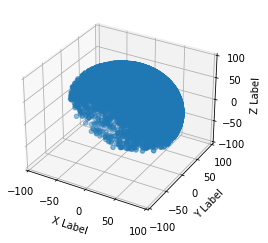

In [223]:
data_length = 10000
random.seed(0)
# The absolute length is just a scaling of little significane. Experimental magnitud around 80 using MPU9050
M_norm=90
M=np.quaternion(0,M_norm,0,0)

#print(quaternion.as_float_array(M))
#print(np.linalg.norm(quaternion.as_float_array(M)))

qs = quaternion.as_quat_array(np.random.rand(data_length, 4))
X90=[]
X90_ass=[]
x_prev=M
for q in qs:
    # For each random quaternion, use it to rotate M and get a new M with random orientation
    q=q.normalized()
    x=q*x_prev*q.conjugate()
    
    x_a=q*M*q.conjugate()
    X90_ass.append(np.array([x_a.x,x_a.y,x_a.z]))
    
    x_prev=x
    #Create the vector from the imaginary part of the quaternion
    x=np.array([x.x,x.y,x.z])
    X90.append(x)
X90_ass=np.array(X90_ass)
X90=np.array(X90)
assert X90.shape[0]==data_length, "Dimension check."
assert X90.shape[1]==3, "Dimension check."
cg_offset=np.sum(np.sum(np.mean(X90,axis=0)**2))
assert cg_offset<0.5, "Center of gravity check, offset: {}".format(cg_offset)
#Now we have data_length random vectors to play with.

#a is the scaling due to soft iron errors
a=np.array([1.1,1.2,1.2])
#b is the offset due to hard iron errors
b=np.array([0.11,0.13,0.15])
b=np.array([20,10,14])


#Generate expected Y values
Y_norm=np.divide(X90,M_norm)

#Apply error scalings and biases
for row_i in range(X90.shape[0]):
    X90[row_i]=X90[row_i]*a+b    

print(X90.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X90_ass.T[0], X90_ass.T[1], X90_ass.T[2], marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_aspect("auto")
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)
ax.set_zlim(-100,100)
plt.show()

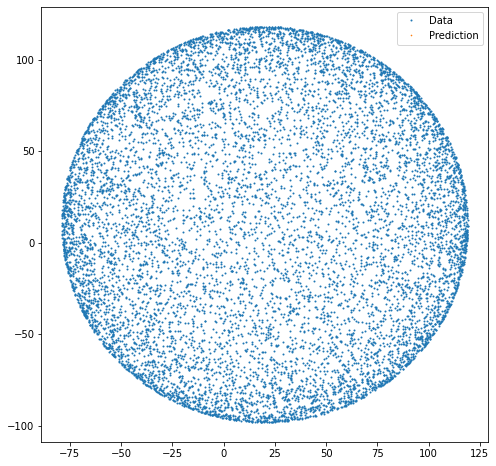

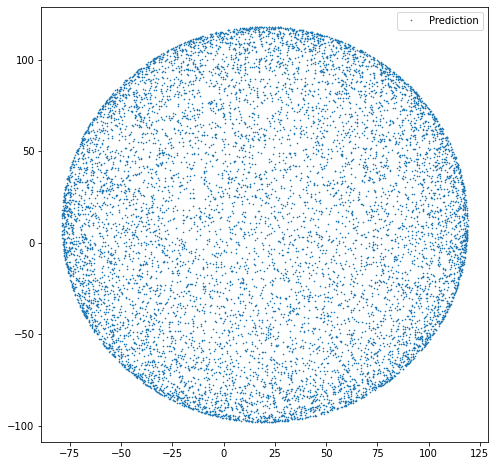

10000/10000 [==============================] - 0s 2us/step
['loss', 'acc', 'mean_squared_error']: [nan, 0.32710000872612, nan]


In [216]:
import keras
from keras import layers
from keras.models import Sequential
from keras.optimizers import SGD, Adam
l_4=layers.Dense(input_dim=3, 
                 units=3, 
                 activation='linear', 
                 kernel_regularizer=unit_regularizer(1e-2), 
                 bias_regularizer=regularizers.l2(1e-2))
layers = [l_4]

learning_rate=1e-2


model = Sequential()
for layer in layers:
    model.add(layer)

model.compile(loss=keras_loss_fn, optimizer=SGD(learning_rate=learning_rate), metrics=["acc","mean_squared_error"])
model.fit(X90,Y90,epochs=1,validation_split=0.1,verbose=False)

P90=model.predict(X90)
plt.figure(figsize=(8, 8))
plt.plot(X90[:,0],X90[:,1],linewidth=0,markersize=1,marker='o',label="Data")
plt.plot(P90[:,0],P90[:,1],linewidth=0,markersize=1,marker='x',label="Prediction")
plt.legend()
plt.show()
plt.figure(figsize=(8, 8))
plt.plot(X90[:,0],X90[:,1],linewidth=0,markersize=1,marker='x',label="Prediction")
plt.legend()
plt.show()
results=model.evaluate(X90,Y_norm,batch_size=256)
print("{}: {}".format(model.metrics_names, results))

As seen, the optimization fails as the SGD algorithm diverges. 
To fix this, one could try playing with the step sizes, but that is quite fiddly and I seem to be failing in finding numerical stability.
The next idea was to instead try to use something eles for the optimizer. 
I tried using Adam, but that did not solve the issue. 

In [175]:
learning_rate=1e-8
model = Sequential()
for layer in layers:
    model.add(layer)
model.compile(loss=keras_loss_fn, optimizer=SGD(learning_rate=learning_rate), metrics=["acc","mean_squared_error"])
model.fit(X,Y,epochs=1,validation_split=0.1,verbose=False)

results=model.evaluate(X,Y,batch_size=256)
print("{}: {}".format(model.metrics_names, results))

10000/10000 [==============================] - 0s 2us/step
['loss', 'acc', 'mean_squared_error']: [nan, 0.28870001435279846, nan]


What if we do an ad-hoc heuristic normalization by normalizing by the first element of the data set before training the model?
I also dropped out the normalization, it does not really help.

10000/10000 [==============================] - 0s 2us/step
['loss', 'acc', 'mean_squared_error']: [4.842075042033045e-11, 0.04569999873638153, 0.7675110101699829]


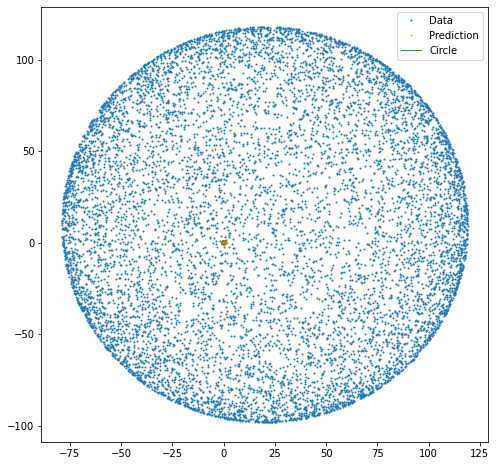

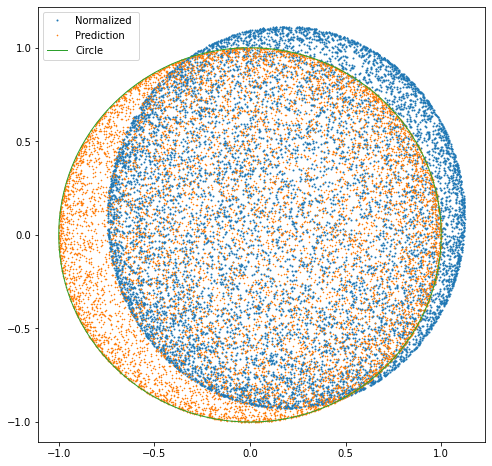

In [231]:
import keras
from keras import layers
from keras.models import Sequential
from keras.optimizers import SGD, Adam
l_5=layers.Dense(input_dim=3, 
                 units=3, 
                 activation='linear')
layers = [l_5]

norm=np.sqrt(np.sum(np.square(X90[0])))
X_norm=np.copy(X90)

for row_i in range(X_norm.shape[0]):
    X_norm[row_i]=np.divide(X_norm[row_i],norm)

learning_rate=1e0

model = Sequential()
for layer in layers:
    model.add(layer)
model.compile(loss=keras_loss_fn, optimizer=SGD(learning_rate=learning_rate), metrics=["acc","mean_squared_error"])
model.fit(X_norm,Y90,epochs=3,validation_split=0.9,verbose=False)

results=model.evaluate(X_norm,Y_norm,batch_size=256)
print("{}: {}".format(model.metrics_names, results))


circle=[]
import math
for i in range(500):
    circle.append([math.sin(6.28*i/500),math.cos(6.28*i/500)])
circle=np.array(circle)

P90=model.predict(X_norm)

#Print raw data and prediction. The scales will be offset with a factor of 100, so the plot is not very useful.
plt.figure(figsize=(8, 8))
plt.plot(X90[:,0],X90[:,1],linewidth=0,markersize=1,marker='o',label="Data")
plt.plot(P90[:,0],P90[:,1],linewidth=0,markersize=1,marker='x',label="Prediction")
plt.plot(circle[:,0],circle[:,1],linewidth=1,markersize=0,label="Circle")
plt.legend()
plt.show()
#Plot the normalized data and the prediction against a circle.
plt.figure(figsize=(8, 8))
plt.plot(X_norm[:,0],X_norm[:,1],linewidth=0,markersize=1,marker='o',label="Normalized ")
plt.plot(P90[:,0],P90[:,1],linewidth=0,markersize=1,marker='x',label="Prediction")
plt.plot(circle[:,0],circle[:,1],linewidth=1,markersize=0,label="Circle")
plt.legend()
plt.show()

Turns out this works pretty well. Cool